In [10]:
import time
import psutil
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.manifold import SpectralEmbedding
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import pickle
import scipy
import pylab as plt
from scipy import sparse
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
#https://github.com/berenslab/rna-seq-tsne/blob/master/demo.ipynb

#Loading the data
#Replaced .. in file paths with /content/drive/MyDrive/LaplacianEigenmap
%%time

# Load the Allen institute data. This takes a few minutes

# This function is needed because using Pandas to load these files in one go
# can eat up a lot of RAM. So we are doing it in chunks, and converting each
# chunk to the sparse matrix format on the fly.
def sparseload(filenames):
    genes = []
    sparseblocks = []
    areas = []
    cells = []
    for chunk1,chunk2 in zip(pd.read_csv(filenames[0], chunksize=1000, index_col=0, na_filter=False),
                             pd.read_csv(filenames[1], chunksize=1000, index_col=0, na_filter=False)):
        if len(cells)==0:
            cells = np.concatenate((chunk1.columns, chunk2.columns))
            areas = [0]*chunk1.columns.size + [1]*chunk2.columns.size

        genes.extend(list(chunk1.index))
        sparseblock1 = sparse.csr_matrix(chunk1.values.astype(float))
        sparseblock2 = sparse.csr_matrix(chunk2.values.astype(float))
        sparseblock = sparse.hstack((sparseblock1,sparseblock2), format='csr')
        sparseblocks.append([sparseblock])
        print('.', end='', flush=True)
    print(' done')
    counts = sparse.bmat(sparseblocks)
    return (counts.T, np.array(genes), cells, np.array(areas))

filenames = ['/content/drive/MyDrive/BUSI/LaplacianEigenmap/data/data/tasic-nature/mouse_VISp_2018-06-14_exon-matrix.csv',
             '/content/drive/MyDrive/BUSI/LaplacianEigenmap/data/data/tasic-nature/mouse_ALM_2018-06-14_exon-matrix.csv']
counts, genes, cells, areas = sparseload(filenames)

genesDF = pd.read_csv('/content/drive/MyDrive/BUSI/LaplacianEigenmap/data/data/tasic-nature/mouse_VISp_2018-06-14_genes-rows.csv')
ids     = genesDF['gene_entrez_id'].tolist()
symbols = genesDF['gene_symbol'].tolist()
id2symbol = dict(zip(ids, symbols))
genes = np.array([id2symbol[g] for g in genes])

clusterInfo = pd.read_csv('/content/drive/MyDrive/BUSI/LaplacianEigenmap/data/data/tasic-nature/sample_heatmap_plot_data.csv')
goodCells  = clusterInfo['sample_name'].values
ids        = clusterInfo['cluster_id'].values
labels     = clusterInfo['cluster_label'].values
colors     = clusterInfo['cluster_color'].values

clusterNames  = np.array([labels[ids==i+1][0] for i in range(np.max(ids))])
clusterColors = np.array([colors[ids==i+1][0] for i in range(np.max(ids))])
clusters   = np.copy(ids) - 1

ind = np.array([np.where(cells==c)[0][0] for c in goodCells])
counts = counts[ind, :]

tasic2018 = {'counts': counts, 'genes': genes, 'clusters': clusters, 'areas': areas,
             'clusterColors': clusterColors, 'clusterNames': clusterNames}
counts = []

.............................................. done
CPU times: user 4min 21s, sys: 17.1 s, total: 4min 38s
Wall time: 5min 3s


In [13]:
#https://github.com/berenslab/rna-seq-tsne/blob/master/demo.ipynb
print('Number of cells:', tasic2018['counts'].shape[0])
print('Number of cells from ALM:', np.sum(tasic2018['areas']==0))
print('Number of cells from VISp:', np.sum(tasic2018['areas']==1))
print('Number of clusters:', np.unique(tasic2018['clusters']).size)
print('Number of genes:', tasic2018['counts'].shape[1])
print('Fraction of zeros in the data matrix: {:.2f}'.format(
    tasic2018['counts'].size/np.prod(tasic2018['counts'].shape)))

#Number of cells from ALM is 15413 vs 9573 in the github
#Number of cells from VISp is 10068 vs 14249 in the github

Number of cells: 23822
Number of cells from ALM: 15413
Number of cells from VISp: 10068
Number of clusters: 133
Number of genes: 45768
Fraction of zeros in the data matrix: 0.20


In [14]:
#https://github.com/berenslab/rna-seq-tsne/blob/master/demo.ipynb
#Pre-processing:

%%time

# Feature selection

def nearZeroRate(data, threshold=0):
    zeroRate = 1 - np.squeeze(np.array((data>threshold).mean(axis=0)))
    return zeroRate

def meanLogExpression(data, threshold=0, atleast=10):
    nonZeros = np.squeeze(np.array((data>threshold).sum(axis=0)))
    N = data.shape[0]
    A = data.multiply(data>threshold)
    A.data = np.log2(A.data)
    meanExpr = np.zeros(data.shape[1]) * np.nan
    detected = nonZeros >= atleast
    meanExpr[detected] = np.squeeze(np.array(A[:,detected].mean(axis=0))) / (nonZeros[detected]/N)
    return meanExpr

def featureSelection(meanLogExpression, nearZeroRate, yoffset=.02, decay=1.5, n=3000):
    low = 0; up=10
    nonan = ~np.isnan(meanLogExpression)
    xoffset = 5
    for step in range(100):
        selected = np.zeros_like(nearZeroRate).astype(bool)
        selected[nonan] = nearZeroRate[nonan] > np.exp(-decay*meanLogExpression[nonan] + xoffset) + yoffset
        if np.sum(selected) == n:
            break
        elif np.sum(selected) < n:
            up = xoffset
            xoffset = (xoffset + low)/2
        else:
            low = xoffset
            xoffset = (xoffset + up)/2
    return selected

x = meanLogExpression(tasic2018['counts'], threshold=32)  # Get mean log non-zero expression of each gene
y = nearZeroRate(tasic2018['counts'], threshold=32)       # Get near-zero frequency of each gene
selectedGenes = featureSelection(x, y, n=3000)            # Adjust the threshold to select 3000 genes

CPU times: user 22.7 s, sys: 7.55 s, total: 30.3 s
Wall time: 30.3 s


In [15]:
#https://github.com/berenslab/rna-seq-tsne/blob/master/demo.ipynb

%%time

counts3k = tasic2018['counts'][:, selectedGenes]  # Feature selection

librarySizes = tasic2018['counts'].sum(axis=1)    # Compute library sizes
CPM = counts3k / librarySizes * 1e+6              # Library size normalisation


logCPM = np.log2(CPM + 1)                         # Log-transformation
logCPM = np.asarray(logCPM)

model = PCA(n_components=50, svd_solver='full')

pca = model.fit(logCPM)  # PCA (TypeError occurs here because logCPM is not an array. Tried to use np.asarray( ) to convert it and IT WORKED!!!!)

flipSigns = np.sum(pca.components_, axis=1) < 0             # fix PC signs
X = pca.transform(logCPM)
X[:, flipSigns] *= -1

print('Shape of the resulting matrix:', X.shape, '\n')


#Principal component analysis

Shape of the resulting matrix: (23822, 50) 

CPU times: user 2min 13s, sys: 9.03 s, total: 2min 22s
Wall time: 1min 27s


In [ ]:
%%time

embedding = SpectralEmbedding(n_components=2, n_neighbors=15, random_state=37)
X_transformed = embedding.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


CPU times: user 7min 38s, sys: 5min 24s, total: 13min 3s
Wall time: 7min 44s


In [43]:
def get_memory_usage():
    process = psutil.Process()
    m = process.memory_info().rss
    mGB = m / (1024 ** 3)
    print (f"{mGB} GB")

get_memory_usage()

4.696437835693359 GB


<ipython-input-44-a0a41c59509c>:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=LE_df, x='LaplacianEigenmap Dimension 1', y='LaplacianEigenmap Dimension 2', palette='tab10', color=tasic2018['clusterColors'][tasic2018['clusters']])


<Axes: title={'center': 'Laplacian Eigenmap'}, xlabel='LaplacianEigenmap Dimension 1', ylabel='LaplacianEigenmap Dimension 2'>

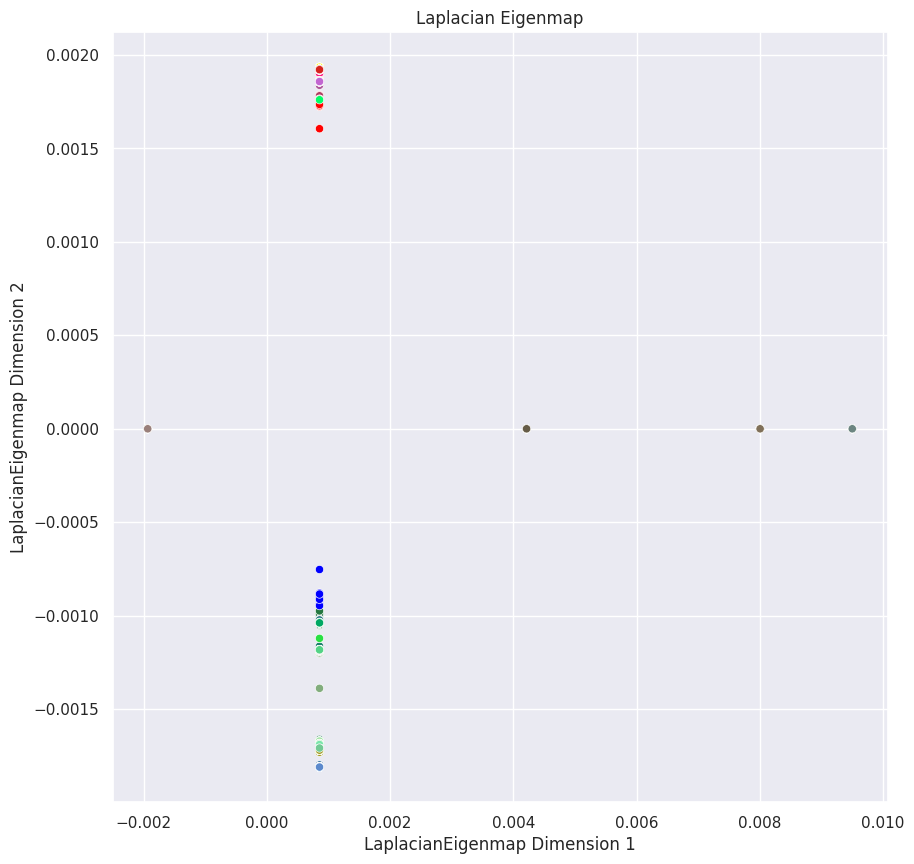

In [44]:
# Plot Laplacian Eigenmap
# Create a DataFrame for visualization
LE_df = pd.DataFrame({
    'LaplacianEigenmap Dimension 1': X_transformed[:, 0],
    'LaplacianEigenmap Dimension 2': X_transformed[:, 1]
})

# Plot the visualization using seaborn
plt.figure(figsize=(10,10))
# plt.gca().invert_xaxis()  # Invert the y-axis direction
plt.title("Laplacian Eigenmap")
sns.scatterplot(data=LE_df, x='LaplacianEigenmap Dimension 1', y='LaplacianEigenmap Dimension 2', palette='tab10', color=tasic2018['clusterColors'][tasic2018['clusters']])